### **Anime Analytics**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector

**Conexión a la base de datos**

In [2]:
try:
    connection = mysql.connector.connect(
        host='localhost',
        user='root',
        password='saito17Jr',
        database='anime'
    )

    if connection.is_connected():
        db_info = connection.server_info
        print(f'Conexión exitosa a MySQL versión {db_info}')

        cursor = connection.cursor()

        lista_secuencia = [
            ('Animes',"SELECT * FROM animes"),
            ('Generos','SELECT * FROM generos'),
            ('Estudio','SELECT * FROM estudios'),
            ('Popularidad','SELECT * FROM popularidad'),
            ('Anime_Generos','SELECT * FROM anime_generos'),
            ('Anime_Estudios','SELECT * FROM anime_estudios'),
        ]

        dic_df = {}

        for df_name, query in lista_secuencia:
            cursor.execute(query)
            data = cursor.fetchall()
            column_name = [i[0]for i in cursor.description]
            df = pd.DataFrame(data, columns=column_name)
            dic_df[df_name] = df
            print(f'DataFrame -> {df_name}:\n {df.head(3)}')
        

except mysql.connector.Error as e:
    print(f'Error al conectar a MySQL {e}')
finally:
    if connection is not None and connection.is_connected():
        connection.close()
        print(f'\nConexión cerrada')

Conexión exitosa a MySQL versión 8.0.44
DataFrame -> Animes:
    mal_id                           titulo   tipo  episodios  annio temporada  \
0       1                     Cowboy Bebop     TV         26   1998    spring   
1       5  Cowboy Bebop: Tengoku no Tobira  Movie          1      0       N/A   
2       6                           Trigun     TV         26   1998    spring   

                    clasificacion       duracion  \
0  R - 17+ (violence & profanity)  24 min per ep   
1  R - 17+ (violence & profanity)    1 hr 55 min   
2       PG-13 - Teens 13 or older  24 min per ep   

                                            sinopsis  anime_rank  
0  Crime is timeless. By the year 2071, humanity ...          48  
1  Another day, another bounty—such is the life o...         232  
2  Vash the Stampede is the man with a $$60,000,0...         386  
DataFrame -> Generos:
    genero_id nombre_genero
0          1        Action
1         50    Adult Cast
2          2     Adventure
DataF

#### **1.-Tendencias Centrales**

- **¿Cómo han evolucionado las calificaciones promedio desde el año 2000 hasta hoy?**

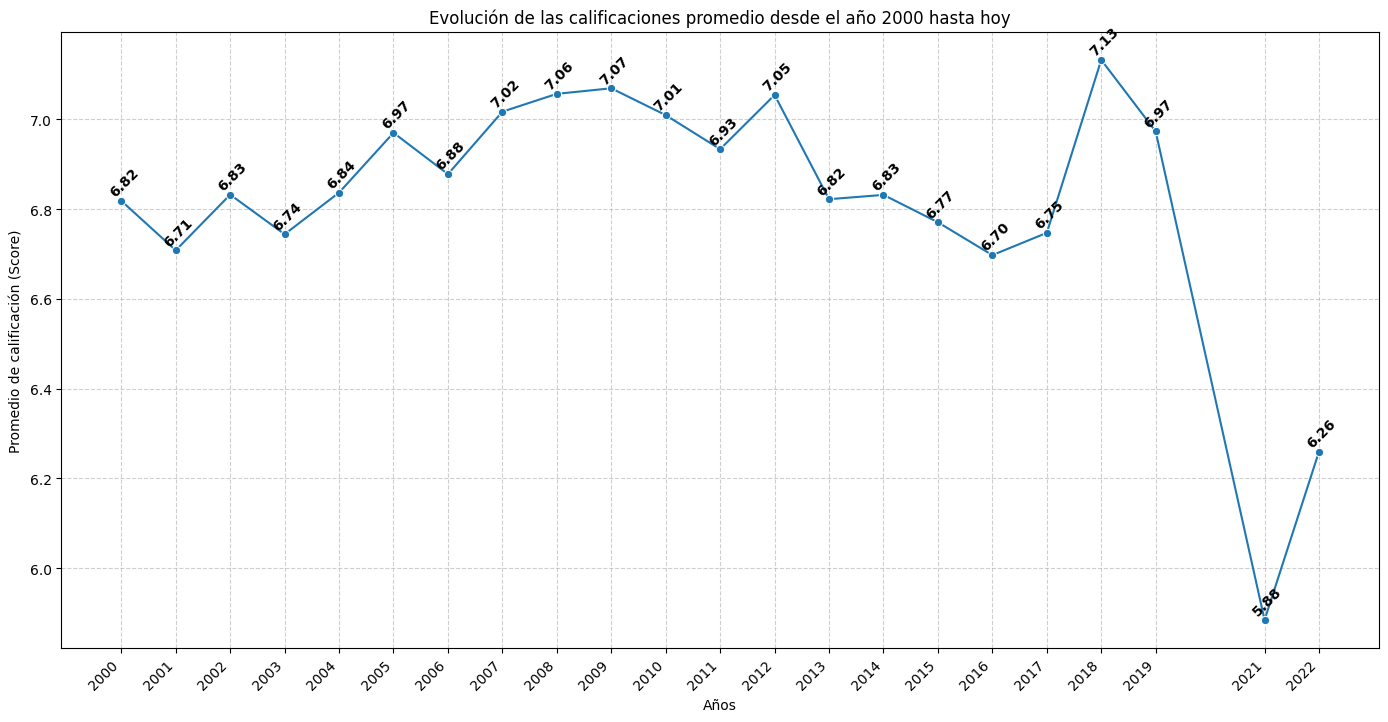

In [3]:
# Obtenciónde df uniendo animes y popularidad
join_animes_popularidad = pd.merge(dic_df['Animes'], dic_df['Popularidad'], on='mal_id', how='inner')
animes_popularidad_mayor_2000 = join_animes_popularidad[(join_animes_popularidad['annio'] >= 2000) & (join_animes_popularidad['score'] < 9999)]
promedio_por_annio = animes_popularidad_mayor_2000.groupby('annio')['score'].mean()
df_promedio_por_anio = promedio_por_annio.reset_index()

# Creación de gráfica
plt.figure(figsize=(17,8))
sns.lineplot(data=df_promedio_por_anio, x='annio', y='score', marker='o')

años_unicos = df_promedio_por_anio['annio'].unique()

plt.xticks(
    ticks=años_unicos, 
    labels=años_unicos,
    rotation=45,  
    ha='right'    
)

plt.title('Evolución de las calificaciones promedio desde el año 2000 hasta hoy')
plt.xlabel('Años')
plt.ylabel('Promedio de calificación (Score)')
plt.grid(True, linestyle='--', alpha=0.6)

for index, row in df_promedio_por_anio.iterrows():
    # Coordenadas X e Y donde se colocará el texto
    x_coord = row['annio']
    y_coord = row['score']
    
    # El valor a mostrar, redondeado a 2 decimales
    valor_texto = f"{y_coord:.2f}"
    
    # Posicionar el texto
    plt.text(
        x=x_coord + 0.05, 
        y=y_coord + 0.01,  # Ajuste (+0.01) para que el texto quede un poco encima del punto
        s=valor_texto, 
        ha='center',       
        fontsize=10,
        weight='bold',
        rotation=45   
    )

plt.show()

* **¿Han aumentado o disminuido la oferta de anime por año y temporada?**

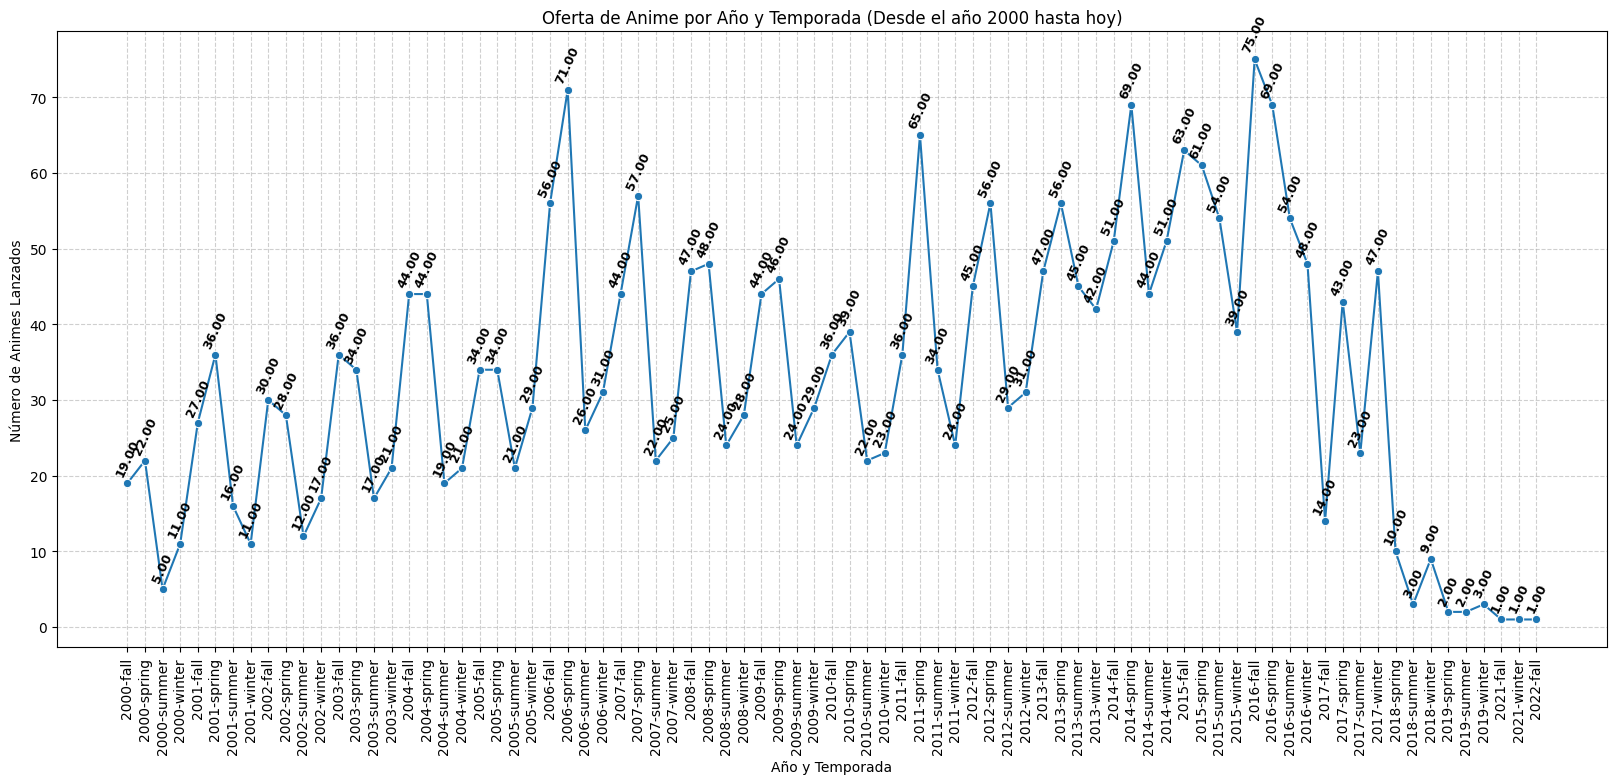

In [4]:

annio_temporada = dic_df['Animes'].groupby(['annio','temporada'])['mal_id'].count()
df_oferta = annio_temporada.to_frame(name='oferta_count').reset_index()
df_oferta = df_oferta[df_oferta['annio'] >= 2000]
# Crear una variable combinada para el eje X
df_oferta['annio_temporada'] = df_oferta['annio'].astype(str) + '-' + df_oferta['temporada']

# Gráfico para ver la tendencia 
plt.figure(figsize=(20, 8))
sns.lineplot(data=df_oferta, x='annio_temporada', y='oferta_count', marker='o')

plt.xticks(rotation=90)
plt.title('Oferta de Anime por Año y Temporada (Desde el año 2000 hasta hoy)')
plt.ylabel('Número de Animes Lanzados')
plt.xlabel('Año y Temporada')
plt.grid(True, linestyle='--', alpha=0.6)

for index, row in df_oferta.iterrows():
    # Coordenadas X e Y donde se colocará el texto
    x_coord = row['annio_temporada']
    y_coord = row['oferta_count']
    
    # El valor a mostrar, redondeado a 2 decimales
    valor_texto = f"{y_coord:.2f}"
    
    # Posicionar el texto
    plt.text(
        x=x_coord, 
        y=y_coord + 1, 
        s=valor_texto, 
        ha='center',       
        fontsize=9,
        weight='bold',
        rotation=65   
    )

plt.show()

#### **2.-Calidad y popularidad**

* **¿Qué géneros tienen mejor desempeño en rating?**

In [5]:
df_generos = dic_df['Generos']
df_generos = df_generos[df_generos['nombre_genero'] != 'Award Winning']

# Unir las tablas 
df_merge = pd.merge(dic_df['Animes'], dic_df['Popularidad'].query('score < 9999'), on='mal_id', how='inner')
anime_populari_anime_generos = pd.merge(df_merge, dic_df['Anime_Generos'], on='mal_id', how='inner')
anime_populari_anime_generos_generos = pd.merge(anime_populari_anime_generos, df_generos, on='genero_id', how='inner')

# Agrupar los datos
genero_ranting = anime_populari_anime_generos_generos.groupby('nombre_genero')['score'].mean().reset_index()
genero_ranting['score'] = genero_ranting['score'].round(2)

genero_ranting = genero_ranting.sort_values(by='score', ascending=False)
genero_ranting

,nombre_genero,score
19,Suspense,7.18
13,Mystery,6.98
14,Romance,6.80
5,Drama,6.79
18,Supernatural,6.75
0,Action,6.68
17,Sports,6.66
1,Adventure,6.63
10,Gourmet,6.56
16,Slice of Life,6.55


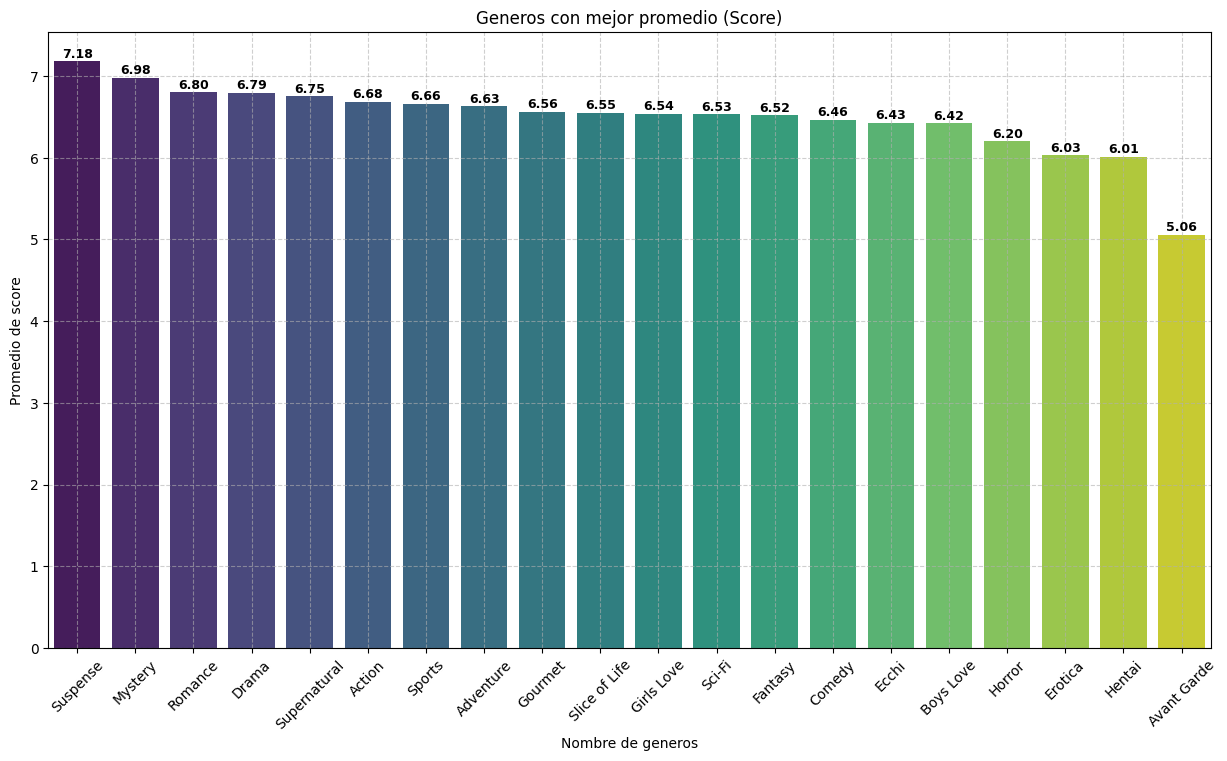

In [6]:
plt.figure(figsize=(15,8))
sns.barplot(data=genero_ranting, x='nombre_genero', y='score', palette='viridis', hue='nombre_genero')
plt.xticks(rotation=45)
plt.title('Generos con mejor promedio (Score)')
plt.xlabel('Nombre de generos')
plt.ylabel('Promedio de score')
plt.grid(True, linestyle='--', alpha=0.6)

for index, row in genero_ranting.iterrows():
    # Coordenadas X e Y donde se colocará el texto
    x_coord = row['nombre_genero']
    y_coord = row['score']
    
    # El valor a mostrar, redondeado a 2 decimales
    valor_texto = f"{y_coord:.2f}"
    
    # Posicionar el texto
    plt.text(
        x=x_coord, 
        y=y_coord + 0.05, 
        s=valor_texto, 
        ha='center',       
        fontsize=9,
        weight='bold' 
    )
plt.show()

* **¿Existen géneros que dominan en ciertas decadas?**

In [7]:
df_animes = dic_df['Animes']
df_animes = df_animes[df_animes['annio'] >= 2000]
# Unir las tablas
animes_merge_anime_generos = pd.merge(df_animes, dic_df['Anime_Generos'], on='mal_id', how='inner')
merge_animes_generos = pd.merge(animes_merge_anime_generos, df_generos, on='genero_id', how='inner')

# Calcular el inicio de la decada
merge_animes_generos['decada'] = (merge_animes_generos['annio'] // 10) * 10

df_volumen = merge_animes_generos.groupby(['decada', 'nombre_genero'])['mal_id'].count().reset_index(name='conteo')

def ranking(df):
    df['rank'] = df['conteo'].rank(method='min', ascending=False)
    return df

df_ranking = df_volumen.groupby('decada').apply(ranking)

df_ranking =  df_ranking[['nombre_genero','conteo','rank']].reset_index()
df_dominante = df_ranking.query('rank == 1').sort_values(by='decada', ascending=False)
df_dominante[['decada','nombre_genero','conteo']]

C:\Users\52771\AppData\Local\Temp\ipykernel_10416\1925919228.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ranking = df_volumen.groupby('decada').apply(ranking)


,decada,nombre_genero,conteo
39,2020,Sci-Fi,3
22,2010,Comedy,654
4,2000,Comedy,537


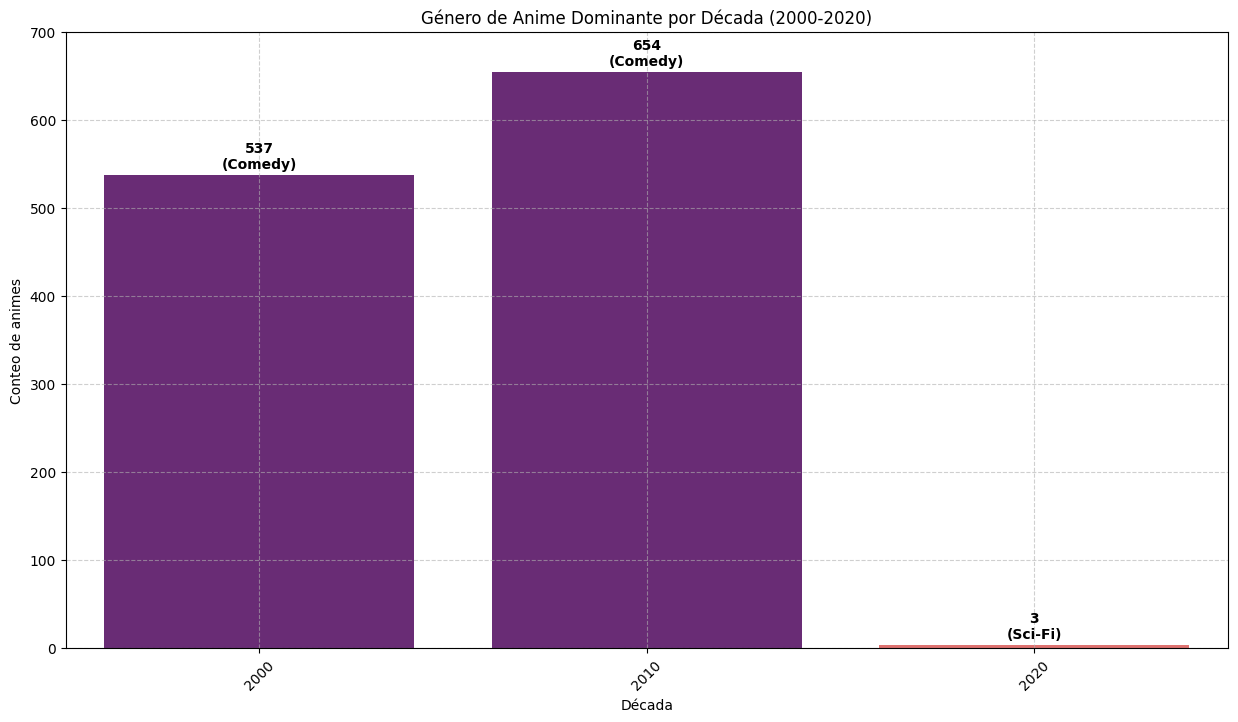

In [8]:
plt.figure(figsize=(15,8))
plt.ylim(0,700)
ax = sns.barplot(data=df_dominante, x='decada', y='conteo', palette='magma', hue='nombre_genero', legend=False)
plt.xticks(rotation=45)
plt.title('Género de Anime Dominante por Década (2000-2020)')
plt.xlabel('Década')
plt.ylabel('Conteo de animes')
plt.grid(True, linestyle='--', alpha=0.6)

for p in ax.patches:
    altura = p.get_height()
    
    if altura > 0:
        x_pos = p.get_x() + p.get_width() / 2
        
        genero_decada = df_dominante[df_dominante['conteo'] == altura]
        
        if not genero_decada.empty:
            genero_str = genero_decada['nombre_genero'].iloc[0]
            
            label_text = f'{int(altura)}\n({genero_str})'
            
            ax.text(
                x=x_pos,        
                y=altura + 5,   
                s=label_text,   
                ha='center',    
                va='bottom',    
                fontsize=10,
                fontweight='bold'
            )

plt.show()

* **¿Qué diferencia a un anime con rating sobresaliente de uno promedio?**

In [9]:
def categorizacion(score):
    if score >= 8.5:
        return 'Sobresaliente'
    elif score >= 6.0 and score < 8.5:
        return 'Promedio'
    else:
        return 'Bajo'

# Exlución de valors imputados
df_animes = dic_df['Animes']
df_popularidad = dic_df['Popularidad']
df_animes = df_animes[(df_animes['tipo'] != 'N/A') & (df_animes['episodios'] < 9999)]
df_popularidad = df_popularidad[(df_popularidad['score'] < 9999) & (df_popularidad['scored_by'] < 9999)]

# Unir las tablas
merge_anime_popularidad = pd.merge(df_animes, df_popularidad, on='mal_id', how='inner')

merge_anime_popularidad['categoria'] = merge_anime_popularidad['score'].apply(categorizacion)

resumen_diferencia = merge_anime_popularidad.groupby('categoria').agg(
    Total_Animes=('mal_id', 'count'),
    Avg_Episodios=('episodios', 'mean'),
    Avg_Votos=('scored_by', 'mean'),
    Avg_Popularidad=('popularidad', 'mean')
).round(0).reset_index()

resumen_diferencia

,categoria,Total_Animes,Avg_Episodios,Avg_Votos,Avg_Popularidad
0,Bajo,3696,8.0,937.0,13648.0
1,Promedio,4437,16.0,2945.0,9314.0


#### **3. Estudios de animación**

* **¿Qué estudios producen los animes mejor valorados?**

In [10]:
df_animes = dic_df['Animes']
df_popularidad = dic_df['Popularidad']
df_popularidad = df_popularidad[df_popularidad['score'] < 9999]
anime_popularidad = pd.merge(df_animes, df_popularidad, on='mal_id', how='inner')

anime_popularidad_anime_estudios = pd.merge(anime_popularidad, dic_df['Anime_Estudios'], on='mal_id', how='inner')
merge_estudios_animes_mejor_valorado = pd.merge(anime_popularidad_anime_estudios, dic_df['Estudio'], on='estudio_id', how='inner')

group_estudios = merge_estudios_animes_mejor_valorado.groupby('nombre_estudio')['score'].mean().round(2).reset_index()
group_estudios = group_estudios.sort_values(by='score', ascending=False)
group_estudios

,nombre_estudio,score
148,Egg Firm,8.41
248,K-Factory,8.40
349,Nippon Ramayana Film,8.39
458,Science SARU,8.17
353,Nut,7.96
...,...,...
584,Sunny Gapen,4.34
51,Arcturus,4.32
162,Filmlink International,4.24
577,Studio! Cucuri,4.14


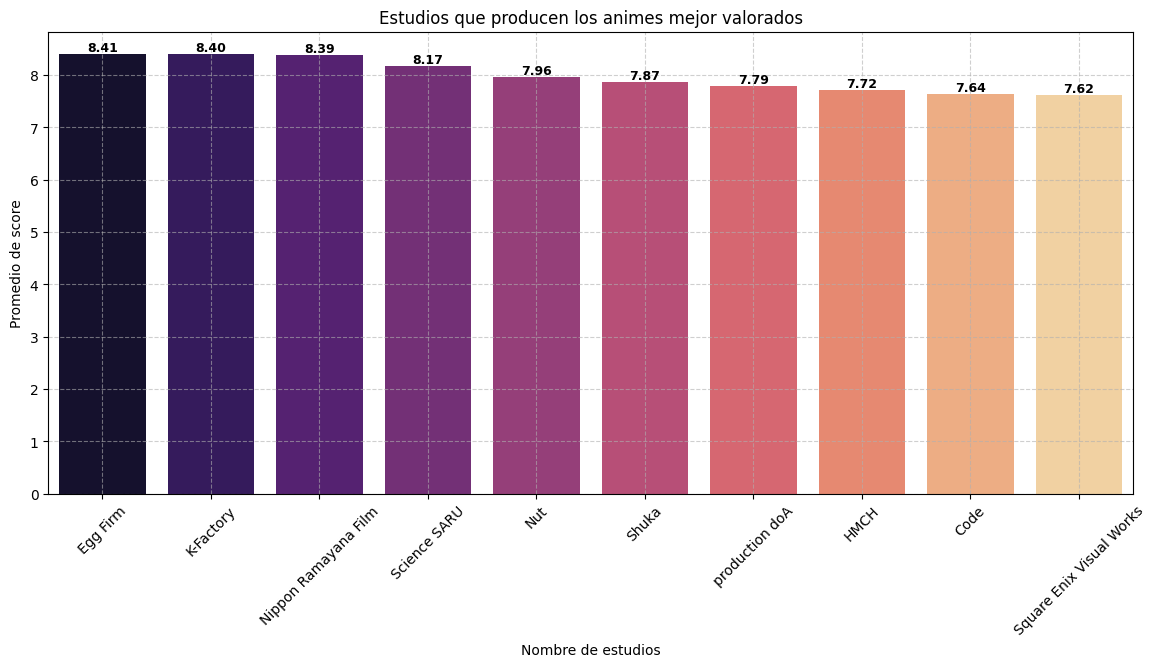

In [11]:
plt.figure(figsize=(14,6))
sns.barplot(data=group_estudios.head(10), x='nombre_estudio', y='score', palette='magma', hue='nombre_estudio')
plt.xticks(rotation=45)
plt.title('Estudios que producen los animes mejor valorados')
plt.xlabel('Nombre de estudios')
plt.ylabel('Promedio de score')
plt.grid(True, linestyle='--', alpha=0.6)

for index, row in group_estudios.head(10).iterrows():
    # Coordenadas X e Y donde se colocará el texto
    x_coord = row['nombre_estudio']
    y_coord = row['score']
    
    # El valor a mostrar, redondeado a 2 decimales
    valor_texto = f"{y_coord:.2f}"
    
    # Posicionar el texto
    plt.text(
        x=x_coord, 
        y=y_coord + 0.05, 
        s=valor_texto, 
        ha='center',       
        fontsize=9,
        weight='bold' 
    )

plt.show()

#### **4. Producción**

* **¿Cuántos episodios tiene cada anime y su duración?**

In [12]:
df_animes = dic_df['Animes']
df_animes = df_animes[df_animes['tipo'] == 'TV']
grupo_anime_duración = df_animes.groupby(['titulo','duracion'])['episodios'].sum().reset_index()
grupo_anime_duración

,titulo,duracion,episodios
0,.hack//Roots,24 min per ep,26
1,.hack//Sign,24 min per ep,26
2,.hack//Tasogare no Udewa Densetsu,23 min per ep,12
3,0-sen Hayato,15 min per ep,38
4,009-1,24 min per ep,12
...,...,...,...
3803,iDOLM@STER Xenoglossia,23 min per ep,26
3804,s.CRY.ed,24 min per ep,26
3805,xxxHOLiC,24 min per ep,24
3806,xxxHOLiC◆Kei,24 min per ep,13


* **¿Cuál es la duración por episodios más común en los animes?**

In [13]:
grupo_duración_cantidad = df_animes.groupby('duracion')['mal_id'].count().reset_index()
grupo_duración_cantidad.sort_values(by='mal_id', ascending=False).head(10)

,duracion,mal_id
26,24 min per ep,1399
24,23 min per ep,773
28,25 min per ep,562
49,5 min per ep,139
33,3 min per ep,138
21,22 min per ep,138
16,2 min per ep,80
40,4 min per ep,62
1,1 min per ep,61
3,10 min per ep,46


* **¿Qué relación existe entre la duración del anime y su rating?**

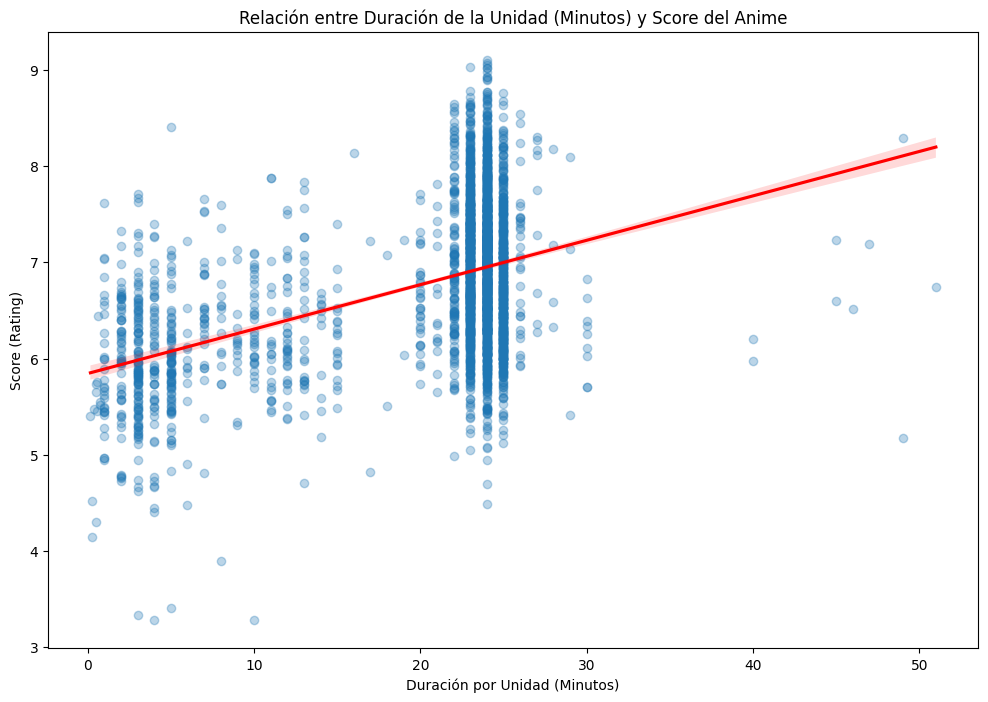

In [30]:
import numpy as np
import re

def limpiar_y_convertir_unidad_duracion(duracion_str):

    if pd.isna(duracion_str) or duracion_str in ['Unknown', 'N/A']:
        return np.nan

    # Normalizar: eliminar etiquetas de unidad y espacios
    duracion_str = duracion_str.lower().replace('.', '')
    # Remover ' per ep', ' per batch', ' per item', etc., para aislar la duración de la unidad
    duracion_str = re.sub(r' per\s+(ep|batch|item)', '', duracion_str)

    total_segundos = 0
    
    # Búsqueda de Horas, Minutos y Segundos
    
    # Horas
    horas_match = re.search(r'(\d+)\s*hr', duracion_str)
    if horas_match:
        total_segundos += int(horas_match.group(1)) * 3600

    # Minutos
    minutos_match = re.search(r'(\d+)\s*min', duracion_str)
    if minutos_match:
        total_segundos += int(minutos_match.group(1)) * 60

    # Segundos
    segundos_match = re.search(r'(\d+)\s*sec', duracion_str)
    if segundos_match:
        total_segundos += int(segundos_match.group(1))

    if total_segundos == 0:
        return np.nan

    # Devolver la duración de la UNIDAD en minutos
    return total_segundos / 60


df_animes = dic_df['Animes']
df_popularidad = dic_df['Popularidad']
df_animes = df_animes[df_animes['tipo'] == 'TV']
df_popularidad = df_popularidad[df_popularidad['score'] < 9999]

merge_anime_popularidad = pd.merge(df_animes, df_popularidad, on='mal_id', how='inner')

merge_anime_popularidad['duracion_min_unidad'] = merge_anime_popularidad['duracion'].apply(
    limpiar_y_convertir_unidad_duracion
)

df_analisis_final = merge_anime_popularidad.dropna(subset=['duracion_min_unidad'])

plt.figure(figsize=(12,8))
sns.regplot(
    data=df_analisis_final, 
    x='duracion_min_unidad', 
    y='score', 
    scatter_kws={"alpha": 0.3},
    line_kws={"color": "red"}
)

plt.title('Relación entre Duración de la Unidad (Minutos) y Score del Anime')
plt.xlabel('Duración por Unidad (Minutos)') # Ahora este eje no pasará de 200 minutos
plt.ylabel('Score (Rating)')
plt.show()

#### **5. Estacionalidad**

* **¿Qué temporada (invierno, primavera, verano, otoño) concentra más títulos?**

In [36]:
df_animes = dic_df['Animes']
df_animes = df_animes[(df_animes['annio'] > 2000) & (df_animes['temporada'] != 'N/A')]

group_temporada_titulos_estrenados = df_animes.groupby('temporada')['mal_id'].sum().reset_index(name='cantidad_animes_estrenados')
group_temporada_titulos_estrenados = group_temporada_titulos_estrenados.sort_values(by='cantidad_animes_estrenados', ascending=False)
group_temporada_titulos_estrenados

,temporada,cantidad_animes_estrenados
1,spring,11816399
0,fall,9911850
3,winter,8192770
2,summer,7696127


* **¿Hay patrones en los ratings según temporada de estreno?**